In [1]:
import os
import time
import random
import collections

import gym
from gym import wrappers
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
from utilities.models import DDPG
from utilities.utils import mkdir, live_plot

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

---
---
---

##### Environment

In [4]:
env_name = 'LunarLanderContinuous-v2'
save_models = True
seed = 202

##### Initialize environment and set seeds

In [5]:
env = gym.make(env_name)

env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [6]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

##### Create folder in which trained models will be saved

In [7]:
if all([save_models, not os.path.exists('./pytorch_models')]):
    os.makedirs('./pytorch_models')
if all([save_models, not os.path.exists('./pytorch_models/all_ddpg')]):
    os.makedirs('./pytorch_models/all_ddpg')

In [8]:
file_name = f'DDPG_{env_name}_{seed}'
print(file_name)

DDPG_LunarLanderContinuous-v2_202


##### Initialize agent parameters

In [9]:
buffer_size = 1e5
batch_size = 100

gamma = 0.99
tau = 5e-3
policy_freq = 2
lr = 1e-3

policy_noise = 0.2
noise_clip = 0.5
expl_noise = 1.1 

##### Initialize agent

In [11]:
agent = DDPG(
    state_dim, 
    action_dim, 
    max_action,
    eta=lr,
)


---

##### Initialize training variables 

In [12]:
#agent.load(file_name, './pytorch_models')

In [13]:
starting_step = 2e4 # Number of random steps at start
max_steps = 1000 # Max steps per episode

episodes = 1500
total_steps = 0
training = False
report = 50

In [14]:
reward_trace = collections.defaultdict(list)

##### Plot noise decay

In [15]:
def noise_decay(eta, step, decay=3e-5):
    #return eta
    return eta * 1/(decay*step + 1)

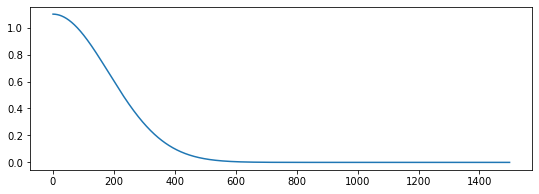

In [16]:
trace = []
eta = expl_noise

for i in np.arange(episodes):
    eta = noise_decay(eta, i)

    trace.append(eta)

plt.figure(figsize=(9,3))
plt.plot(trace)
plt.show()

##### Training:

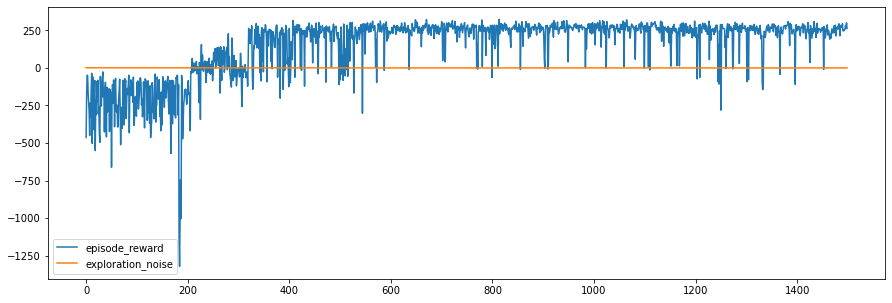

In [17]:
for episode in np.arange(1, episodes):             
    
    obs = env.reset()
    done = False
    episode_reward = []
    steps = 0
    
    
    
    while not done:        
        
        if total_steps == starting_step:
            print('Begin training')
            training = True
            
        if not training:
            action = env.action_space.sample()
        else:
            action = agent.select_action(np.array(obs))
            
            if expl_noise != 0:
                noise = np.random.normal(0, expl_noise, size=env.action_space.shape[0])
                action = (action+noise).clip(env.action_space.low, env.action_space.high)
                
        new_obs, reward, done, info = env.step(action)
        
        done = (done) or (steps >= max_steps)
        #reward *= 2 if steps >= max_steps else 1 ###

        episode_reward.append(reward)
        agent.replay_buffer.add((obs, new_obs, action, reward, int(done)))
        
        obs = new_obs
        steps += 1
        total_steps += 1


    if training:
        expl_noise = noise_decay(expl_noise, episode) ###
    
    agent.train(steps, batch_size, gamma, policy_noise, noise_clip)
    reward_trace['episode_reward'].append(sum(episode_reward))
    reward_trace['exploration_noise'].append(round(expl_noise, 9))
    
    ax = live_plot(reward_trace)
    plt.show()
 
    if episode % report == 0:
        
        print('Episode:', episode)
        print('Average score:', np.mean(reward_trace['episode_reward'][-report:]))
        print('Exploration noise:', reward_trace['exploration_noise'][-1])
        print('Training:', training)
        time.sleep(1)
        
        agent.save(
            f'{file_name}_{episode}', 
            './pytorch_models/all_ddpg',
        )
        

In [21]:
total_steps

465949

In [22]:
episode

1499

In [23]:
expl_noise

6.722155273269623e-15

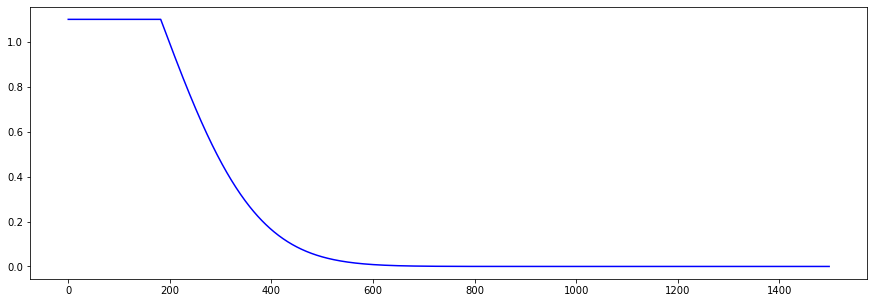

In [24]:
plt.figure(figsize=(15,5))
plt.plot(reward_trace['exploration_noise'], 'b')
plt.show()

##### Plot reward trace

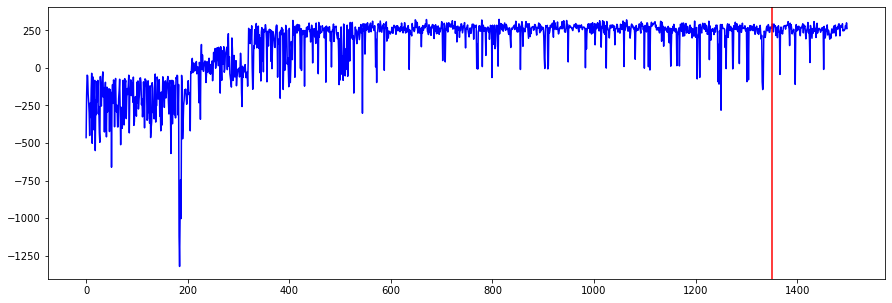

In [31]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['episode_reward'], 'b')
#plt.plot(reward_trace['episode_reward'][:10], 'r')

plt.axvline(1350, c='r')
plt.show()

##### Save only model from selected point in training history

In [32]:
idx = 1350

agent.load(
    f'{file_name}_{idx}', 
    './pytorch_models/all_ddpg',
)

agent.save(
    file_name, 
    './pytorch_models',
)

for item in os.listdir('./pytorch_models/all_ddpg'):
    os.remove(os.path.join('./pytorch_models/all_ddpg', item))

---

In [47]:
agent.load(file_name, './pytorch_models')

In [48]:
max_steps = 1000 # Max steps per episode
episodes = 500
report = 10

In [49]:
reward_trace = collections.defaultdict(list)

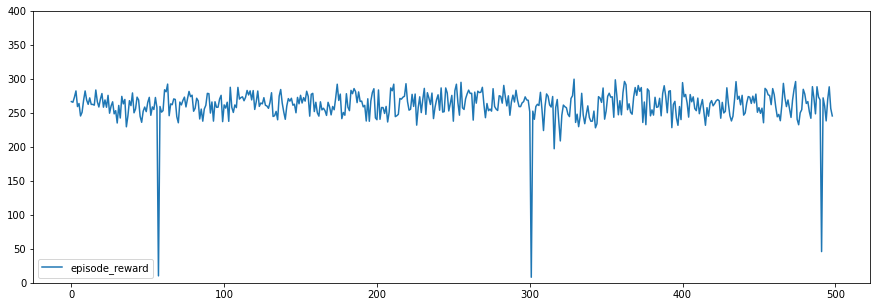

In [50]:
for episode in np.arange(1, episodes):             
    
    obs = env.reset()
    done = False
    episode_reward = []
    steps = 0
    
    
    
    while not done:        
        
        action = agent.select_action(np.array(obs))
                
        new_obs, reward, done, info = env.step(action)
        
        done = (done) or (steps >= max_steps)
        
        episode_reward.append(reward)
        
        obs = new_obs
        steps += 1


    
    reward_trace['episode_reward'].append(sum(episode_reward))
    ax = live_plot(reward_trace)
    ax.set_ylim([0, 400])
    plt.show()
 
    if episode % report == 0:
        
        print('Episode:', episode)
        print('Average score:', np.mean(reward_trace['episode_reward'][-report:]))
        time.sleep(1)
        
    

In [51]:
np.mean(reward_trace['episode_reward'])

261.6725117397457